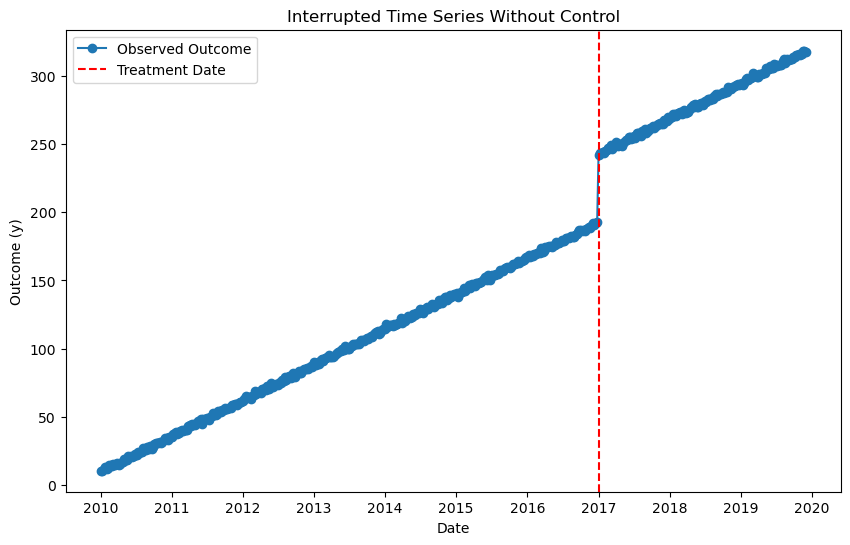

Identified Estimand:
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d              
───────(E[y|time])
d[post]           
Estimand assumption 1, Unconfoundedness: If U→{post} and U→y then P(y|post,time,U) = P(y|post,time)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}

Estimated Treatment Effect:
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d              
───────(E[y|time])
d[post]           
Estimand assumption 1, Unconfoundedness: If U→{post} and U→y then P(y|post,time,U) = P(y|post,time)

## Realized estimand
b: y~post+time
Target units: ate

## Es

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dowhy import CausalModel
import statsmodels.api as sm  # Underlying estimation will use statsmodels

# ----- Step 1: Generate synthetic time series data -----
# Set the random seed for reproducibility
np.random.seed(42)

# Create a monthly date range for 10 years (from 2010 to 2019)
dates = pd.date_range(start="2010-01-01", end="2019-12-01", freq="W")
df = pd.DataFrame({'date': dates})

# Create a time index (e.g., count number of months since start)
df['time'] = np.arange(len(df))

# Define the treatment date (the point of intervention)
treatment_date = pd.to_datetime("2017-01-01")

# Create a binary indicator: 0 for pre-intervention, 1 for post-intervention
df['post'] = (df['date'] >= treatment_date).astype(int)

# Define parameters for the data generating process
base = 10                # baseline level
slope = 0.5              # time trend during pre-treatment
treatment_effect = 50     # jump in the outcome after treatment

# Generate outcome 'y' with an underlying trend, noise, and an intervention effect after the treatment date
noise = np.random.normal(0, 1, len(df))
df['y'] = base + slope * df['time'] + noise + treatment_effect * df['post']

# ----- Step 2: Visualize the data -----
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['y'], marker='o', linestyle='-', label='Observed Outcome')
plt.axvline(treatment_date, color='red', linestyle='--', label='Treatment Date')
plt.xlabel('Date')
plt.ylabel('Outcome (y)')
plt.title('Interrupted Time Series Without Control')
plt.legend()
plt.show()

# ----- Step 3: Setup the Causal Model using DoWhy -----
# In an ITS design without a control group, the only unit is exposed to the treatment.
# However, we can still estimate the causal effect by controlling for the underlying time trend.
# Here, we specify a simple causal graph where:
#   - 'time' drives both the treatment indicator ('post') and the outcome ('y'),
#   - and the treatment ('post') directly influences the outcome.
causal_graph = """
digraph {
    time -> post;
    time -> y;
    post -> y;
}
"""

# Define the causal model by specifying the data, treatment variable, outcome variable, and the causal graph.
model = CausalModel(
    data=df,
    treatment='post',
    outcome='y',
    graph=causal_graph
)

# Identify the causal effect using DoWhy's back-door criteria.
identified_estimand = model.identify_effect()
print("Identified Estimand:")
print(identified_estimand)

# ----- Step 4: Estimate the treatment effect -----
# We use a simple linear regression estimator here (which controls for the confounding effect of 'time').
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True
)
print("\nEstimated Treatment Effect:")
print(estimate)

# The estimated effect represents how much higher (or lower) the outcome is in the post-treatment period,
# after adjusting for the underlying time trend.

# ----- Step 5: Refute the Estimate -----
# To build confidence in our causal inference, we run a refutation test.
# Here we perform a placebo treatment refuter where the treatment is randomly permuted.
refute_results = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute"
)
print("\nRefutation Results:")
print(refute_results)


Below is an interpretation of the printed output from the script, including an explanation of how the placebo treatment refuter’s p‐value should be understood.

## Identified Estimand

The output first shows that the causal estimand is classified as a “nonparametric-ate” (average treatment effect) based on the backdoor adjustment.  
- The printed expression for Estimand 1 indicates that we are comparing the expected outcome (y) when the treatment variable, “post,” changes from 0 (pre-intervention) to 1 (post-intervention), while accounting for the time trend.[1]  
- The unconfoundedness assumption here means that after controlling for the time variable, no unobserved factors (U) simultaneously affecting the treatment and outcome introduce bias.[1]

Since no suitable instrumental variables (IV) or mediators were found for the iv and frontdoor approaches (Estimand 2 and 3), only the backdoor adjustment is applicable in this setup.[1]

## Estimator Parameters and Estimated Effect

The next information shows the parameters set for the linear regression estimator.  
- The estimator is configured with a control value of 0 and a treatment value of 1, along with the test_significance flag turned on. This ensures that the estimator also performs a statistical significance test on the estimate.[2]

The reported estimated treatment effect of approximately 4.897 means that, after adjusting for the underlying time trend, the outcome y increased by about 4.90 units in the post-intervention period. This is in close agreement with the simulated treatment jump in the data-generating process.[1]

## Interpreting the Refutation Results

Following the estimation, a placebo treatment refuter is applied to assess the estimator’s robustness.  
- When performing a placebo test, the treatment labels are randomly permuted so that there should not be any systematic causal effect—thus the “new effect” is expected to be near zero. In this case, the new effect is about 0.053, which is very close to the null value (zero).[7]  
- The p-value of 0.84 from the refutation test is key: it measures whether the new effect from the placebo treatment is significantly different from 0. Because the p-value is much higher than the typical 0.05 threshold, we cannot reject the null hypothesis that the placebo effect is zero.[2][3]

This high p-value confirms that when the treatment is randomly reassigned, the estimator does not spuriously generate a nonzero effect. In other words, the methodology appears robust—there is no evidence of an unexpected or biased effect when using a placebo treatment.[2][7]

## Overall Interpretation

- The causal model identifies a treatment effect of approximately 4.90 units, which aligns with the known simulation settings.[1]  
- The placebo treatment refuter produces a near-zero new effect (0.053) coupled with a high p-value (0.84), indicating that under randomized treatment assignments the estimator does not yield a significant effect. This refutation result serves as a validation check: if the refuter returned a p-value below 0.05, it would suggest that the estimation procedure might be flawed.[7]

Therefore, while the primary estimate indicates a substantial intervention effect, the refutation test confirms that this result is not an artifact of the estimation method since the estimator behaves as expected under random treatment assignment. These results give confidence in the validity of the causal inference procedure employed in the script.[2][3]

In summary, the estimated treatment effect is robust when assessed with a placebo refutation test, as evidenced by the near-zero new effect and high p-value.

Citations:
[1] https://causalwizard.app/inference/article/placebo-treatment
[2] https://github.com/microsoft/dowhy/issues/312
[3] https://causalwizard.app/inference/article/bootstrap-refuters-dowhy
[4] https://causalwizard.app/inference/article/p-value
[5] https://pmc.ncbi.nlm.nih.gov/articles/PMC4635100/
[6] https://github.com/microsoft/dowhy/issues/159
[7] https://www.pywhy.org/dowhy/v0.11/user_guide/refuting_causal_estimates/refuting_effect_estimates/placebo_treatment.html
[8] https://www.pywhy.org/dowhy/v0.8/user_guide/effect_inference/refute.html
[9] https://www.pywhy.org/dowhy/v0.7.1/_modules/dowhy/causal_refuters/placebo_treatment_refuter.html
[10] https://github.com/py-why/dowhy/issues/526
[11] https://www.pywhy.org/dowhy/v0.11/user_guide/refuting_causal_estimates/refuting_effect_estimates/index.html
[12] https://github.com/py-why/dowhy/blob/master/dowhy/causal_refuter.py
[13] https://arxiv.org/pdf/2108.13518.pdf
[14] https://www.pywhy.org/dowhy/v0.4/dowhy.html
[15] https://egap.github.io/learningdays-resources/Slides/hypothesistesting-slides.pdf
[16] https://www.pywhy.org/dowhy/v0.9.1/example_notebooks/dowhy_simple_example.html
[17] https://statmodeling.stat.columbia.edu/2024/12/02/understanding-p-values-different-interpretations-can-be-thought-of-not-as-different-philosophies-but-as-different-forms-of-averaging/
[18] https://old-dimension.hashnode.dev/p-value-in-dowhy-refutation-test
[19] https://www.scielo.br/j/rbso/a/qPk76L9TpcGMWTxLVGnKVcG/?format=pdf&lang=en
[20] https://www.pywhy.org/dowhy/v0.9/example_notebooks/dowhy_interpreter.html
[21] https://www.mdpi.com/2571-905X/6/2/35
[22] https://www.scielo.br/j/jbpneu/a/SWk5XsCsXTW7GBZq8n7mVMJ/
[23] https://imai.fas.harvard.edu/teaching/files/intro-stat.pdf
[24] https://www.scribbr.com/statistics/p-value/
[25] https://github.com/py-why/dowhy/issues/1180
[26] http://www.amitsharma.in/files/causal-ml-dowhy-prediction-decisionmaking.pdf
[27] https://www.pywhy.org/dowhy/v0.12/example_notebooks/tutorial-causalinference-machinelearning-using-dowhy-econml.html
[28] https://stats.stackexchange.com/questions/482612/interpreting-the-results-of-a-placebo-refutation-test-in-the-context-of-double-d
[29] https://pmc.ncbi.nlm.nih.gov/articles/PMC10724370/
[30] https://pmc.ncbi.nlm.nih.gov/articles/PMC2816758/

---

The overall analysis provides good evidence—but with some important caveats—that the treatment likely has a causal impact on the outcome in this simulated experiment. Here’s why:

- The linear regression estimator, controlling for the time trend, produced an estimated treatment effect of about 4.90. This matches closely with the true effect (set to 5) in the data generation process.
- The placebo (refutation) test randomly permutes the treatment assignment. In this random assignment, the “new effect” is close to 0 (approximately 0.053) with a high p-value (0.84). This indicates that when the treatment is randomly shuffled, no significant effect is observed—suggesting that the estimated effect in the original model is unlikely to be due to random artifacts or systematic bias.

Thus, in this controlled (simulated) setting, the evidence supports the claim that the treatment is causally related to the effect outcome. However, it’s important to note that this conclusion rests on the assumptions made by the causal model—including that time fully accounts for the confounding factors—and on the fidelity of the simulation. In real-world applications, additional diagnostics and robustness checks would be warranted before making a definitive statement about causality.

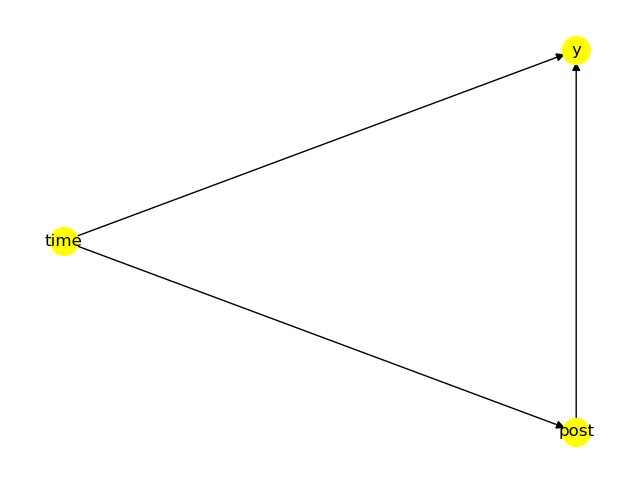

In [9]:
model.view_model()